In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pickle

from dataset import *

print(torch.__version__)
print(torch.version.cuda)
print(torchaudio.__version__)

2.2.2+cu118
11.8
2.2.2+cu118


In [3]:
# Function to list all available GPUs and their details
def list_gpus():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"Total number of available GPU(s): {num_gpus}\n")
        
        for i in range(num_gpus):
            print(f"GPU {i}:")
            print(f"  Name: {torch.cuda.get_device_name(i)}")
            print(f"  Capability: {torch.cuda.get_device_capability(i)}")
            print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
            print(f"  Multiprocessors: {torch.cuda.get_device_properties(i).multi_processor_count}")
            # print(f"  Maximum Threads per Block: {torch.cuda.get_device_properties(i).max_threads_per_block}")
            print("-" * 40)
    else:
        print("No CUDA-enabled GPU is available.")

# Call the function to list GPUs
list_gpus()


Total number of available GPU(s): 4

GPU 0:
  Name: Tesla T4
  Capability: (7, 5)
  Total Memory: 15.65 GB
  Multiprocessors: 40
----------------------------------------
GPU 1:
  Name: Tesla T4
  Capability: (7, 5)
  Total Memory: 15.65 GB
  Multiprocessors: 40
----------------------------------------
GPU 2:
  Name: Tesla T4
  Capability: (7, 5)
  Total Memory: 15.65 GB
  Multiprocessors: 40
----------------------------------------
GPU 3:
  Name: Tesla T4
  Capability: (7, 5)
  Total Memory: 15.65 GB
  Multiprocessors: 40
----------------------------------------


In [4]:
video_dataset_frame_items = pickle.load(open("preprocessing/video_dataset_list.pkl", "rb"))

In [5]:
len(video_dataset_frame_items)

20001087

In [6]:
import numpy as np

video_dataset_frame_items = np.array(video_dataset_frame_items)

In [7]:
import random

def manual_train_val_test_split(dataset_size, train_frac=0.8, val_frac=0.1):
    indices = list(range(dataset_size))
    random.shuffle(indices)  # Shuffle the indices to ensure random splitting

    # Calculate split sizes
    train_end = int(train_frac * dataset_size)
    val_end = train_end + int(val_frac * dataset_size)

    # Split the indices
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    return train_indices, val_indices, test_indices

train_indices, val_indices, test_indices = manual_train_val_test_split(len(video_dataset_frame_items))

train_frames = video_dataset_frame_items[train_indices]
val_frames = video_dataset_frame_items[val_indices]
test_frames = video_dataset_frame_items[test_indices]

print(len(train_frames))
print(len(val_frames))
print(len(test_frames))

16000869
2000108
2000110


In [8]:
import torchvision.transforms as transforms

frame_transforms = transforms.Compose([
    transforms.ToPILImage(),        # Convert the tensor to PIL image
    transforms.Resize((128, 128)),  # Resize to 128x128 for uniformity
    transforms.ToTensor(),          # Convert the PIL image back to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

train_dataset = TalkingFaceFrameDataset(train_frames, frame_transforms=frame_transforms)
val_dataset = TalkingFaceFrameDataset(val_frames, frame_transforms=frame_transforms)
test_dataset = TalkingFaceFrameDataset(test_frames, frame_transforms=frame_transforms)

del video_dataset_frame_items, train_frames, val_frames, test_frames

In [9]:
a, b = train_dataset[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


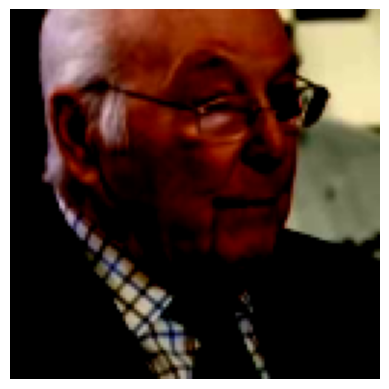

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


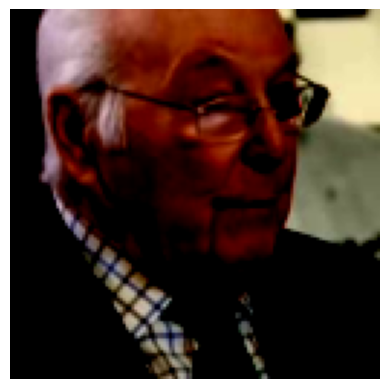

In [10]:
import matplotlib.pyplot as plt

def display_image(image):
    if image.dtype == torch.float32:  # Check if the image is a float type
        if image.max() > 1.0:  # Assume the range should be [0, 1]
            image = image / 255.0  # Scale down if it was in [0, 255]
    image = image.numpy()  # Convert to numpy array if it's a tensor
    if len(image.shape) == 3 and image.shape[0] in [3, 4]:  # CHW format
        image = image.transpose((1, 2, 0))  # Convert to HWC format for matplotlib

    plt.imshow(image)
    plt.axis('off')
    plt.show()

display_image(a)
display_image(b)

In [11]:
# device = 'cuda'

# from diffusion import Diffusion
# from unet import UNet

# image_size = 128
# in_channels = 3
# model_channels = 32
# out_channels = 3
# num_res_blocks = 1
# attention_resolutions = (8, 4, 2)
# dropout = 0.1
# channel_mult = (1, 2, 3)
# num_heads = 2
# num_head_channels = -1
# resblock_updown = True

# unet = UNet(image_size, in_channels, model_channels, out_channels, num_res_blocks, attention_resolutions, dropout=dropout, channel_mult=channel_mult, num_heads=num_heads, num_head_channels=num_head_channels, resblock_updown=resblock_updown, id_condition_type='frame', precision=32).to(device)
# diffusion = Diffusion(unet, 10, in_channels, image_size, out_channels, 32)

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

from diffusion import Diffusion
from unet import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model configuration
image_size = 128
in_channels = 3
model_channels = 32
out_channels = 3
num_res_blocks = 1
attention_resolutions = (8, 4, 2)
dropout = 0.1
channel_mult = (1, 2, 3)
num_heads = 2
num_head_channels = -1
resblock_updown = True

# Initialize UNet and Diffusion model
unet = UNet(image_size, in_channels, model_channels, out_channels, num_res_blocks, attention_resolutions, dropout=dropout, channel_mult=channel_mult, num_heads=num_heads, num_head_channels=num_head_channels, resblock_updown=resblock_updown, id_condition_type='frame', precision=32)
unet.to(device)

diffusion = Diffusion(unet, 10, in_channels, image_size, out_channels, 32)
diffusion.to(device)

Using device: cuda


Diffusion(
  (nn_backbone): UNet(
    (time_embed): TimestepEmbedding(
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (audio_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (input_blocks): ModuleList(
      (0): CondSequential(
        (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): CondSequential(
        (0): CondResBlock(
          (in_layers): Sequential(
            (0): GroupNorm(32, 32, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (t_emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(

In [13]:
# Apply DataParallel if multiple GPUs are available
# if torch.cuda.device_count() > 1:
#     print(f"Using 4 {torch.cuda.device_count()} GPUs.")
#     diffusion = nn.DataParallel(diffusion)

# DataLoader and optimizer
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
optimizer = optim.Adam(diffusion.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    for batch_idx, (x, x_cond) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epochs}")):
        torch.cuda.empty_cache()
        
        x = x.to(device)
        x_cond = x_cond.to(device)

        optimizer.zero_grad()

        losses = diffusion(x, x_cond)
        loss = losses['simple'].mean()  # Using .mean() to handle DataParallel output correctly
        if 'vlb' in losses:
            loss += losses['vlb'].mean()
        if 'lip' in losses:
            loss += losses['lip'].mean()
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{n_epochs} completed, Average Loss: {avg_epoch_loss}")


Epoch 1/10:   0%|          | 0/2000109 [00:00<?, ?it/s]

: 